In [1]:
import pandas as pd
import yfinance as yf
import numpy as np

In [2]:
df = yf.download(
    "MSFT",
    start="2012-01-01",
    end="2021-12-31",
    progress=False
)

In [3]:
#df = df.head(100)

In [4]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,26.549999,26.959999,26.389999,26.770000,21.238756,64731500
2012-01-04,26.820000,27.469999,26.780001,27.400000,21.738583,80516100
2012-01-05,27.379999,27.730000,27.290001,27.680000,21.960726,56081400
2012-01-06,27.530001,28.190001,27.530001,28.110001,22.301878,99455500
2012-01-09,28.049999,28.100000,27.719999,27.740000,22.008331,59706800
...,...,...,...,...,...,...
2021-12-23,332.750000,336.390015,332.730011,334.690002,328.062042,19617800
2021-12-27,335.459991,342.480011,335.429993,342.450012,335.668365,19947000
2021-12-28,343.149994,343.809998,340.320007,341.250000,334.492188,15661500


### Convert prices into returns

By transforming the prices into returns we aim at make the time series stationary. There are two types of returns:

- Simple returns: they aggregate over assets: eg
  $$R_t = \frac{P_t}{P_{t-1}-1}$$
  
- Log returns: they aggregate over time:
  $$r_t = \log\Bigg(\frac{P_t}{P_{t-1}}\Bigg)$$

In general log returns are preferred since, if we assume that the stock-prices are log-normally distributed, then the log returns would be normally distributed.

In [5]:
#df = df[["Close"]]
df = df.loc[:, ["Close"]]
#df["simple_rtn"] = df.Close.pct_change()  # percentage change from pandas package
df["log_rtn"] = np.log(df.Close/df.Close.shift(1))
df.dropna(inplace=True)


### Adjusting for inflation

We want to decouple the growth of the stock prices from the inflation. We can do so by using this formula 
$$ R^r_t = \frac{1+R_t}{1+\pi_t}-1$$

where $\pi_t$ is the inflation rate.

In [6]:
# Import the Consumer Price Index from the cpi package and query the correct entries
'''
import cpi 
cpi.update()
cpi_series = cpi.series.get()
df_cpi = cpi_series.to_dataframe()
df_cpi.query("period_type == 'monthly' and year > 2010") \
    .loc[:, ["date", "value"]] \
    .set_index("date") \
    .head(12)
'''

'\nimport cpi \ncpi.update()\ncpi_series = cpi.series.get()\ndf_cpi = cpi_series.to_dataframe()\ndf_cpi.query("period_type == \'monthly\' and year > 2010")     .loc[:, ["date", "value"]]     .set_index("date")     .head(12)\n'

### Scaling data to (0,1)

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(df)
scaled_data = scaler.transform(df)
scaled_df = pd.DataFrame(scaled_data, index=df.index, columns=df.columns)
scaled_df

,Close,log_rtn
Date,,
2012-01-04,0.003252,0.624916
2012-01-05,0.004136,0.580133
2012-01-06,0.005493,0.598082
2012-01-09,0.004325,0.500042
2012-01-10,0.004641,0.557666
...,...,...
2021-12-23,0.973417,0.560619
2021-12-27,0.997916,0.623753
2021-12-28,0.994128,0.533353


# Train/test split

In [16]:
split = int(len(scaled_df) * 0.8)
train = df[:split]
test = df[split:]

In [17]:
from finance.core.functions import preprocess_data

n = 3
target_col = 'log_rtn'

X_train, y_train = preprocess_data(train, n=n, target_column=target_col)
X_test, y_test = preprocess_data(test, n=n, target_column=target_col)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2009, 3, 2)
(2009,)
(500, 3, 2)
(500,)


In [18]:
y_train.iat[0]
val = np.array(y_train.iat[0])
val = np.c_[val,np.zeros(val.shape)]
print(val)
scaler.inverse_transform(val)

[[-0.01325  0.     ]]


array([[22.17319605, -0.15945341]])

In [19]:
df[ np.isclose( df['Close'], 2.80209039e+01 ) ]

,Close,log_rtn
Date,,


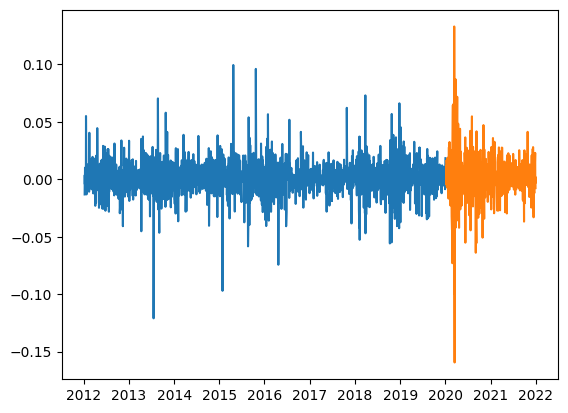

In [20]:
import matplotlib.pyplot as plt 

plt.plot(y_train)
plt.plot(y_test)

In [21]:
from finance.core.functions import lstm_model

model = lstm_model(X_train, y_train, X_test, y_test)
model.summary()

Epoch 1/100


/home/marco/Desktop/ATOM/Finance/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


84/84 - 2s - 19ms/step - loss: 0.2319 - val_loss: 5.1334e-04
Epoch 2/100
84/84 - 0s - 3ms/step - loss: 0.0043 - val_loss: 7.2312e-04
Epoch 3/100
84/84 - 0s - 3ms/step - loss: 0.0025 - val_loss: 7.8434e-04
Epoch 4/100
84/84 - 0s - 2ms/step - loss: 0.0018 - val_loss: 7.0792e-04
Epoch 5/100
84/84 - 0s - 2ms/step - loss: 0.0014 - val_loss: 5.8561e-04
Epoch 6/100
84/84 - 0s - 2ms/step - loss: 0.0011 - val_loss: 5.1165e-04
Epoch 7/100
84/84 - 0s - 2ms/step - loss: 8.7906e-04 - val_loss: 4.8436e-04
Epoch 8/100
84/84 - 0s - 2ms/step - loss: 7.1980e-04 - val_loss: 4.7268e-04
Epoch 9/100
84/84 - 0s - 3ms/step - loss: 6.0607e-04 - val_loss: 4.6953e-04
Epoch 10/100
84/84 - 0s - 3ms/step - loss: 5.3209e-04 - val_loss: 4.6711e-04
Epoch 11/100
84/84 - 0s - 2ms/step - loss: 4.5910e-04 - val_loss: 4.7010e-04
Epoch 12/100
84/84 - 0s - 2ms/step - loss: 4.1393e-04 - val_loss: 4.8288e-04
Epoch 13/100
84/84 - 0s - 2ms/step - loss: 3.7446e-04 - val_loss: 4.8311e-04
Epoch 14/100
84/84 - 0s - 2ms/step - loss: 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 5)              │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 500 (1.96 KB)

 Trainable params: 166 (664.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 334 (1.31 KB)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


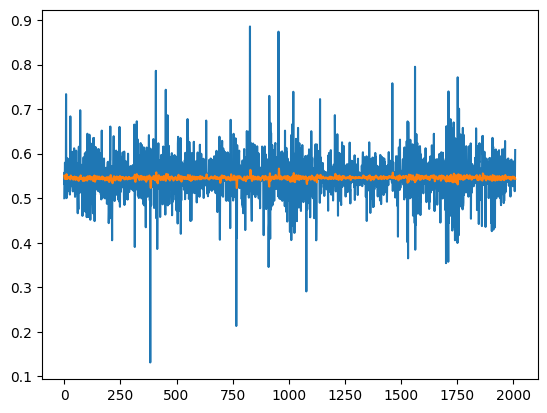

In [14]:
y_pred = model.predict(X_train)

plt.plot(y_train.values)
plt.plot(y_pred)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


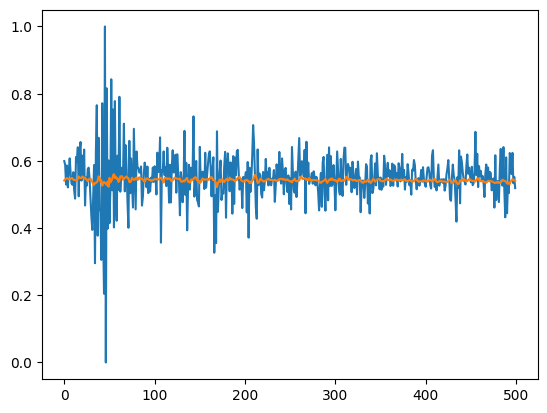

In [15]:
y_pred = model.predict(X_test)

plt.plot(y_test.values)
plt.plot(y_pred)